<a href="https://colab.research.google.com/github/lanpty58/mystudy/blob/main/Multi_layer_Perceptron_(MLP).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!gdown --id 1fB9P1Ha1ofQiYWU9wkLAxDZTbtp3Gfqz

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1fB9P1Ha1ofQiYWU9wkLAxDZTbtp3Gfqz
To: /content/Auto_MPG_data.csv
100% 15.4k/15.4k [00:00<00:00, 25.1MB/s]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)

In [ ]:
dataset = pd.read_csv('/content/Auto_MPG_data.csv')
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1


In [ ]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
val_dataset = dataset.drop(train_dataset.index)


In [ ]:
X_train = train_dataset.copy()
X_val = val_dataset.copy()

y_train = X_train.pop('MPG')
y_val = X_val.pop('MPG')

X_train, y_train = torch.tensor(X_train.values, dtype = torch.float32), torch.tensor(y_train.values, dtype = torch.float32)
X_val, y_val = torch.tensor(X_val.values, dtype = torch.float32), torch.tensor(y_val.values, dtype = torch.float32)

In [ ]:
mean = X_train.mean(axis = 0)
std = X_train.std(axis = 0)

X_train = (X_train - mean)/std
X_val = (X_val - mean)/std

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.y)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]


In [ ]:
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 32)

In [ ]:
class MLP(nn.Module):
  def __init__(self, input_dims, hidden_dims, output_dims):
    super(MLP, self).__init__()
    self.layer1 = nn.Linear(input_dims, hidden_dims)
    self.relu = nn.ReLU()
    self.hidden_layer = nn.Linear(hidden_dims, hidden_dims)
    self.output = nn.Linear(hidden_dims, output_dims)

  def forward(self, x):
    x = self.layer1(x)
    x = self.relu(x)
    x = self.hidden_layer(x)
    x = self.relu(x)
    x = self.output(x)
    return x.squeeze(1)



In [ ]:
model = MLP(input_dims=9, hidden_dims=64, output_dims=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr = 0.003)

In [ ]:
def r_squared(y_true, y_pred):
  y_true = torch.Tensor(y_true)
  y_pred = torch.Tensor(y_pred)
  mean_true = torch.mean(y_true)
  ss_tot = torch.sum((y_true - mean_true)**2)
  ss_res = torch.sum((y_true - y_pred)**2)
  r2 = 1 - (ss_res/ss_tot)
  return r2

In [ ]:
num_epochs = 100
train_losses = []
val_losses = []
train_r2 = []
val_r2 = []

for epoch in range(num_epochs):
  model.train()
  train_loss = 0.0
  train_target = []
  val_target = []
  train_predict = []
  val_predict = []
  for X, y in train_loader:
    X, y = X.to(device), y.to(device)
    optimizer.zero_grad()
    y_hat = model(X)
    # train_predict.extend(y_hat.tolist())
    # train_target.extend(y.tolist())
    loss = criterion(y_hat, y)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

  train_loss /= len(train_loader)
  train_losses.append(train_loss)
  # train_r2.append(r_squared(train_target, train_predict))

  model.eval()
  val_loss = 0.0
  with torch.no_grad():
    for X, y in val_loader:
      X, y = X.to(device), y.to(device)
      y_pred = model(X)
      # val_predict.extend(y_pred.tolist())
      # val_target.extend(y.tolist)
      loss = criterion(y_pred, y)
      val_loss += loss.item()

  val_loss /= len(val_loader)
  val_losses.append(val_loss)
  # val_r2.append(r_squared(val_target, val_predict))
  print(f'Epoch: {epoch +1}/{num_epochs}, Train loss: {train_loss: .3f}, Validation loss: {val_loss: .3f}')

Epoch: 1/100, Train loss:  349.424, Validation loss:  27.181
Epoch: 2/100, Train loss:  20.497, Validation loss:  11.384
Epoch: 3/100, Train loss:  17.720, Validation loss:  9.490
Epoch: 4/100, Train loss:  11.427, Validation loss:  9.207
Epoch: 5/100, Train loss:  9.783, Validation loss:  8.902
Epoch: 6/100, Train loss:  8.995, Validation loss:  7.564
Epoch: 7/100, Train loss:  10.583, Validation loss:  17.129
Epoch: 8/100, Train loss:  8.223, Validation loss:  8.657
Epoch: 9/100, Train loss:  8.355, Validation loss:  7.662
Epoch: 10/100, Train loss:  7.983, Validation loss:  10.780
Epoch: 11/100, Train loss:  8.231, Validation loss:  7.142
Epoch: 12/100, Train loss:  7.510, Validation loss:  6.659
Epoch: 13/100, Train loss:  8.282, Validation loss:  13.248
Epoch: 14/100, Train loss:  8.301, Validation loss:  6.731
Epoch: 15/100, Train loss:  7.603, Validation loss:  7.908
Epoch: 16/100, Train loss:  7.269, Validation loss:  8.649
Epoch: 17/100, Train loss:  7.684, Validation loss:  7

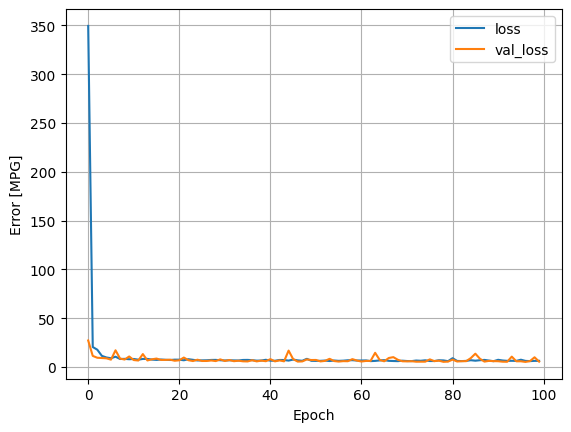

In [ ]:
plt.plot(train_losses, label = 'loss')
plt.plot(val_losses, label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error [MPG]')
plt.legend()
plt.grid(True)